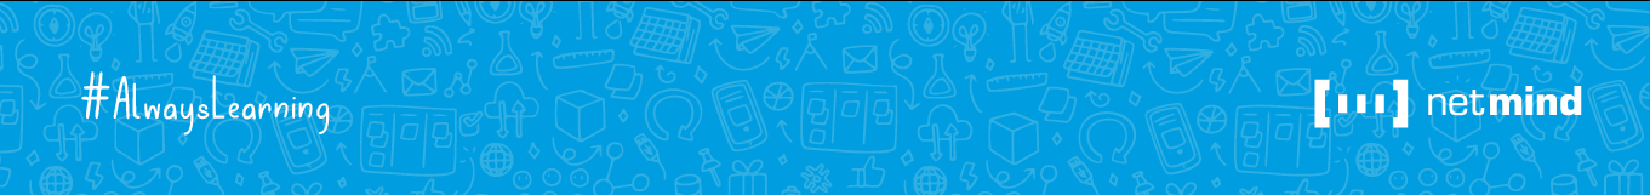
# **Despliegue de un modelo en un endpoint gestionado**

- Para consumir una modelo, se debe desplegar. 
- Una manera de desplegarlo es como un servicio que permita a las aplicaciones solicitar predicciones instantáneas o en tiempo real, para conjuntos de datos individuales o pequeños.
- En Azure Machine Learning, se puede usar endpoints para desplegar y consumir un modelo.


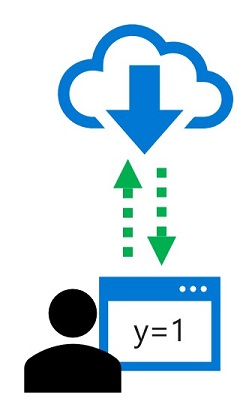

## **Endpoints administrados**

Para obtener predicciones en tiempo real, se puede desplegar un modelo en un endpoint. 
- Un punto de conexión HTTPS al que puede enviar datos y que devolverá una respuesta (casi) inmediata.
- Los datos que envíen al punto de conexión servirán como entrada para el script de puntuación hospedado en el punto de conexión. 
- El script de puntuación carga el modelo entrenado para predecir la etiqueta de los nuevos datos de entrada, lo que también se conoce como inferencia. 
- La etiqueta forma parte de la salida que se devuelve.

En Azure Machine Learning, hay dos tipos de puntos de conexión en línea:
- Puntos de conexión en línea administrados: Azure Machine Learning administra toda la infraestructura subyacente.
- Puntos de conexión en línea de Kubernetes: los usuarios administran el clúster de Kubernetes, que proporciona la infraestructura necesaria.

Como científico de datos, es posible que se prefiera trabajar con puntos de conexión en línea administrados para probar si el modelo funciona según lo previsto cuando se implementa. 
- Si se requiere un punto de conexión en línea de Kubernetes para controlar y escalar, es probable que otros equipos lo administren.
- Si se usa un punto de conexión en línea administrado, solo se tiene que especificar el tipo de máquina virtual (VM) y la configuración de escalado. 
    - Todo lo demás, como aprovisionar la potencia de proceso y actualizar el sistema operativo host (SO), se realiza automáticamente.

## **Despliegue del modelo**

Después de crear un endpoint en el área de trabajo, se puede deplegar un modelo en ese endpoint, especificando cuatro cosas:
- **Recursos de modelo** como el archivo pickle del modelo o un modelo registrado en el área de trabajo de Azure Machine Learning.
- **Script de puntuación** que carga el modelo.
- **Entorno** que enumera todos los paquetes necesarios que deben instalarse en el proceso del endpoint.
- **Configuración de escalado**, incluidos el tamaño de proceso y la configuración de escalado para asegurarse de que puede controlar la cantidad de solicitudes que recibirá el endpoint.
 Importante

Al deplegar modelos de MLFlow en un endpoint, no es necesario proporcionar un script de puntuación y un entorno, ya que ambos se generan automáticamente.

Todos estos elementos se definen en el **despliegue**: básicamente un conjunto de recursos necesarios para hospedar el modelo que realiza la inferencia.

### Despliegue azul-verde
Un endpoint puede tener varias implementaciones. Un enfoque es el despliegue azul/verde.

Por ejemplo, para un modelo de recomendación de restaurantes. 
- Después de la experimentación, se selecciona el modelo con mejor rendimiento. 
- El despliegue azul se usa para la primera versión del modelo. 
    - Cuando se recopilan nuevos datos, el modelo se puede volver a entrenar y se registra una nueva versión en el área de trabajo de Azure Machine Learning. 
    - Para probar el nuevo modelo, se puede usar el despliegue verde para la segunda versión del modelo.
- Ambas versiones del modelo se implementan en el mismo endpoint, que se integra con la aplicación. 
    - Dentro de la aplicación, un usuario selecciona un restaurante y envía una solicitud al endpoint para obtener nuevas recomendaciones en tiempo real de otros restaurantes que le podrían gustar al usuario.
    - Cuando se envía una solicitud al endpoint, el 90 % del tráfico puede ir a el despliegue azul, y el 10 % del tráfico puede ir a el despliegue verde. 
    - Con dos versiones del modelo implementadas en el mismo endpoint, se puede probar fácilmente el modelo.

Después de las pruebas, también puede realizar una transición fluida a la nueva versión del modelo redirigiendo el 90 % del tráfico a el despliegue verde. 
- Si resulta que la nueva versión no funciona mejor, se puede revertir fácilmente a la primera versión del modelo enrutando de nuevo la mayoría del tráfico a el despliegue azul.

El despliegue azul/verde permite implementar varios modelos en un endpoint. Puede decidir cuánto tráfico se debe desviar a cada modelo implementado. De este modo, se puede cambiar a una nueva versión del modelo sin interrumpir el servicio al consumidor.

> Más información: https://learn.microsoft.com/es-es/azure/machine-learning/how-to-safely-rollout-online-endpoints?view=azureml-api-2&tabs=azure-cli

## **Crear un endpoint**
Para crear un endpoint, se usará la clase [`ManagedOnlineEndpoint`](https://learn.microsoft.com/es-es/python/api/azure-ai-ml/azure.ai.ml.entities.managedonlineendpoint?view=azure-python), que requiere los siguientes parámetros:
- name: Nombre del endpoint. Debe ser único en la región de Azure.
- auth_mode: Use key para la autenticación basada en claves. Use aml_token para la autenticación basada en tokens de Azure Machine Learning.

Ejemplo:

In [ ]:
from azure.ai.ml.entities import ManagedOnlineEndpoint

# create an online endpoint
endpoint = ManagedOnlineEndpoint(
    name="endpoint-example",
    description="Online endpoint",
    auth_mode="key",
)

ml_client.begin_create_or_update(endpoint).result()

## **Despliegue de un modelo de MLflow en un endpoint**
Al implementar un modelo de MLflow en un punto de conexión en línea administrado, no es necesario tener el script de puntuación y el entorno de ejecución.

Para implementar un modelo de MLflow, se debe tener archivos de modelo almacenados en una ruta de acceso local o con un modelo registrado. 
- Se puede registrar archivos de modelos al entrenar un modelo utilizando el seguimiento de MLflow.
- https://learn.microsoft.com/en-us/azure/machine-learning/how-to-deploy-mlflow-models?view=azureml-api-2&tabs=azureml

Todos los archivos se deben almacenar en una carpeta local denominada model. 
- La carpeta debe incluir el archivo MLmodel, que describe cómo se puede cargar y usar el modelo.
    - https://learn.microsoft.com/es-es/azure/machine-learning/concept-mlflow-models#the-mlmodel-format?azure-portal=true
- Junto al modelo, también debe especificar la configuración de proceso para la implementación:
    - `instance_type`: tamaño de máquina virtual (VM) que se va a usar. Revise la lista de tamaños admitidos.
    - `instance_count`: número de instancias que se van a usar.

Para implementar (y registrar automáticamente) el modelo:

In [ ]:
from azure.ai.ml.entities import Model, ManagedOnlineDeployment
from azure.ai.ml.constants import AssetTypes

# create a blue deployment
model = Model(
    path="./model",
    type=AssetTypes.MLFLOW_MODEL,
    description="my sample mlflow model",
)

blue_deployment = ManagedOnlineDeployment(
    name="blue",
    endpoint_name="endpoint-example",
    model=model,
    instance_type="Standard_F4s_v2",
    instance_count=1,
)

ml_client.online_deployments.begin_create_or_update(blue_deployment).result()

Dado que solo se implementa un modelo en el endpoint, el modelo tomará el 100 % del tráfico. 
- Al implementar varios modelos en el mismo endpoint, puede distribuir el tráfico entre los modelos implementados.

Para enrutar el tráfico a una implementación específica:

In [ ]:
# blue deployment takes 100 traffic
endpoint.traffic = {"blue": 100}
ml_client.begin_create_or_update(endpoint).result()

Para eliminar el punto de conexión y todas las implementaciones asociadas:



In [ ]:
ml_client.online_endpoints.begin_delete(name="endpoint-example")

## **Despliegue de un modelo en un endpoint gestionado**

Para desplegar un modelo, se deberá crear el script de puntuación y definir el entorno necesario durante la inferencia.
- Se debe haber creado un endpoint. 
- A continuación, se puede desplegar el modelo en el endpoint.

Para desplegar un modelo debe tener:
- Archivos de modelo almacenados en la ruta de acceso local o en el modelo registrado.
- Un script de puntuación.
- Un entorno de ejecución.

Los archivos de modelo se pueden registrar y almacenar al entrenar un modelo.

### Creación del script de puntuación

El script de puntuación debe incluir dos funciones:

- `init()`: se llama cuando se inicializa el servicio.
- `run()`: se llama cuando se envían nuevos datos al servicio.

Se llama a la función init cuando se crea o actualiza la implementación para cargar y almacenar en caché el modelo desde el registro de modelos. 

Se llama a la función run cada vez que se invoca el punto de conexión para generar predicciones a partir de los datos de entrada. 

**Ejemplo:**

In [ ]:
import json
import joblib
import numpy as np
import os

# called when the deployment is created or updated
def init():
    global model
    # get the path to the registered model file and load it
    model_path = os.path.join(os.getenv('AZUREML_MODEL_DIR'), 'model.pkl')
    model = joblib.load(model_path)

# called when a request is received
def run(raw_data):
    # get the input data as a numpy array
    data = np.array(json.loads(raw_data)['data'])
    # get a prediction from the model
    predictions = model.predict(data)
    # return the predictions as any JSON serializable format
    return predictions.tolist()

### Creación del despliegue

Se puede especificar la configuración de proceso con dos parámetros:

- `instance_type`: tamaño de la máquina virtual (VM) que se va a usar. Revise la lista de tamaños admitidos.
- `instance_count`: número de instancias que se van a usar.

Para desplegar el modelo, usar la clase `ManagedOnlineDeployment`:


In [ ]:
from azure.ai.ml.entities import ManagedOnlineDeployment, CodeConfiguration

model = Model(path="./model",

blue_deployment = ManagedOnlineDeployment(
    name="blue",
    endpoint_name="endpoint-example",
    model=model,
    environment="deployment-environment",
    code_configuration=CodeConfiguration(
        code="./src", scoring_script="score.py"
    ),
    instance_type="Standard_DS2_v2",
    instance_count=1,
)

ml_client.online_deployments.begin_create_or_update(blue_deployment).result()

Se puede desplegar varios modelos en un punto de conexión.

- Para enrutar el tráfico a una implementación específica:

In [ ]:
# blue deployment takes 100 traffic
endpoint.traffic = {"blue": 100}
ml_client.begin_create_or_update(endpoint).result()

- Para eliminar el punto de conexión y todas las implementaciones asociadas:

In [ ]:
ml_client.online_endpoints.begin_delete(name="endpoint-example")

## **Probar un endpoint**

Se puede probar usando Azure ML Studio y SDK.

Normalmente, los datos se envían al modelo desplegado en formato JSON con la estructura siguiente:
```yaml
{
  "data":[
      [0.1,2.3,4.1,2.0], // 1st case
      [0.2,1.8,3.9,2.1],  // 2nd case,
      ...
  ]
}
```

La respuesta del modelo implementado es una colección JSON con una predicción para cada caso que se envió en los datos. 

**Ejemplo**: el siguiente código invoca un endpoint y se muestra la respuesta:

In [ ]:
# test the blue deployment with some sample data
response = ml_client.online_endpoints.invoke(
    endpoint_name=online_endpoint_name,
    deployment_name="blue",
    request_file="sample-data.json",
)

if response[1]=='1':
    print("Yes")
else:
    print ("No")

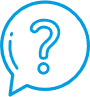
## **¿Preguntas?**


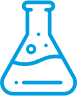
## **Lab 1**

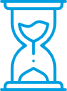
## **Ejercicio**

Usando el pipeline del dataset de precios de casas (data/house_price/data.csv):
- Entrena y despliega un modelo